<a href="https://colab.research.google.com/github/awaldis/ai-notes/blob/main/restaurant_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements in Python the restaurant decision tree algorithm from Chapter 19 in:

Russell, Stuart, and Peter Norvig. *Artificial Intelligence: A Modern Approach.* 4th ed. Pearson, 2020.

In [4]:
import pandas as pd
from google.colab import files
from io import StringIO
import math

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving restaurant.csv to restaurant.csv
User uploaded file "restaurant.csv" with length 848 bytes


In [1]:
import os

In [6]:
os.listdir()

['.config', 'restaurant.csv', 'sample_data']

If reloading the file from the local drive in a single session you must delete the previous file first.  Otherwise, the colab file loader while rename the new file instead of overwriting the old file.

In [38]:
os.remove('restaurant.csv')

Read the data into a pandas data frame.

In [7]:
df = pd.read_csv(StringIO(uploaded['restaurant.csv'].decode() ), skipinitialspace=True, keep_default_na=False)

In [9]:
df

,Alternate,Bar,Fri/Sat,Hungry,Patrons,Price,Raining,Reservation,Type,WaitEstimate,Output
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [10]:
def plurality_value(df):
    return( df['Output'].value_counts().idxmax())

In [11]:
def entropy_boolean(prob):
    """
    Calculate the information entropy of a boolean random variable.

    Args:
        prob: Probability that the random variable is true (or false, either
        way the entropy is the same).

    Returns:
        Entropy in bits.
    """
    if prob > 0 and prob < 1 :
        return(-(prob * math.log2(prob) + ((1 - prob) * math.log2(1 - prob))))
    return(0)


In [12]:
def remaining_entropy(groups, tot_examples):
    """
    Calculate the remaining entropy if we were to split on the given groups.

    Args:
        groups: A pandas GroupBy object.
        tot_examples: The total number of examples in all the groups.

    Returns:
        The remaining entropy in bits.
    """
    output = 0.0  # Start with a remaining entropy of zero.

    # Now accumulate each groups contribution to the remaining entropy.
    for value, group_df in groups:
        counts_series = group_df['Output'].value_counts()

        if 'Yes' in counts_series.index:
            tot_yes = counts_series['Yes']
        else:
            tot_yes = 0

        tot_examples_this_value = len(group_df)
        output += (tot_examples_this_value/tot_examples) * entropy_boolean(tot_yes/tot_examples_this_value)
    return(output)

In [13]:
def max_info_gain(df):
    """
    Determine the attribute with the maximum information gain.

    Args:
        df: A pandas data frame.

    Returns:
        A string with the name of the column that has the maximum information
        gain.
    """
    # TODO - replace constant 1 with actual entropy calculation.
    total_entropy = 1
    max_info_gain = 0.0
    max_info_gain_column = 'Error'

    for column in df.columns:
        if column == 'Output':
            continue
        info_gain = total_entropy - remaining_entropy(df.groupby(column), len(df))
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            max_info_gain_column = column
    return(max_info_gain_column)

#    print(f"{column} :  %.3f" % info_gain)


In [21]:
class TreeNode:
    def __init__(self, name, branch_name):
        print(f"Created node for: {name}")
        self.name = name
        self.children = []
        self.branch_name = branch_name # the branch that leads to this node.

    def add_child(self, child_node ):
        self.children.append(child_node)

    def evaluate(self, input_data):
        if not self.children:
            return self.name

        for child in self.children:
            if input_data[self.name] == child.branch_name:
                return child.evaluate(input_data)

        return None  # No matching child found

In [19]:
def print_tree(node, level=0):
    indent = "  " * level
    print(f"{indent}Node: {node.name}, Branch: {node.branch_name}")
    for child in node.children:
        print_tree(child, level + 1)

In [22]:
def learn_decision_tree(examples, parent_examples, branch_name):

    if not examples.empty:
        column = examples['Output']

        # Check if all examples have the same output classification.
        if column.nunique() == 1:
             # Get the actual value of the unique classification.
             single_classification = column.iloc[0]
             return(TreeNode(single_classification, branch_name))
    else :
        return(TreeNode(plurality_value(parent_examples), branch_name))

#    if attributes empty...

    most_important_attribute = max_info_gain(examples)

    print(f"Found most important attribute: {most_important_attribute}")
    tree = TreeNode(most_important_attribute, branch_name)

    value_groups = examples.groupby(most_important_attribute)

    for value_name, group_df in value_groups:
        print(f"Processing value: {value_name}")
        group_df_mia_dropped = group_df.drop(columns=most_important_attribute)
        print(group_df_mia_dropped.columns)
        subtree = learn_decision_tree(group_df_mia_dropped, examples, value_name)
        tree.add_child(subtree)

    return(tree)

In [23]:
dec_tree = learn_decision_tree(df, df, 'root')


Found most important attribute: Patrons
Created node for: Patrons
Processing value: Full
Index(['Alternate', 'Bar', 'Fri/Sat', 'Hungry', 'Price', 'Raining',
       'Reservation', 'Type', 'WaitEstimate', 'Output'],
      dtype='object')
Found most important attribute: Hungry
Created node for: Hungry
Processing value: No
Index(['Alternate', 'Bar', 'Fri/Sat', 'Price', 'Raining', 'Reservation',
       'Type', 'WaitEstimate', 'Output'],
      dtype='object')
Created node for: No
Processing value: Yes
Index(['Alternate', 'Bar', 'Fri/Sat', 'Price', 'Raining', 'Reservation',
       'Type', 'WaitEstimate', 'Output'],
      dtype='object')
Found most important attribute: Type
Created node for: Type
Processing value: Burger
Index(['Alternate', 'Bar', 'Fri/Sat', 'Price', 'Raining', 'Reservation',
       'WaitEstimate', 'Output'],
      dtype='object')
Created node for: Yes
Processing value: Italian
Index(['Alternate', 'Bar', 'Fri/Sat', 'Price', 'Raining', 'Reservation',
       'WaitEstimate', 'Out

In [39]:
#print_tree(dec_tree)
#row = df.iloc[4]
#row = row[:-1]
for index, row in df.iterrows():
    # Convert the row to a Series
    row_series = row.copy()
    # Remove the last value
    row_series = row_series[:-1]
    # Print the modified row
#    print(f"\nModified Row {index}:")
#    print(row_series)
    print(dec_tree.evaluate(row))

Yes
No
Yes
Yes
No
Yes
No
Yes
No
No
No
Yes


# **Archived code snippets below here:**

In [89]:
uploaded['restaurant.csv']

b'Alternate, Bar, Fri/Sat, Hungry, Patrons, Price, Raining, Reservation, Type, WaitEstimate, Output\nYes, No,  No,  Yes, Some, $$$, No,   Yes, French,  0-10,   Yes\nYes, No,  No,  Yes, Full, $,   No,   No,  Thai,    30-60,  No\nNo,  Yes, No,  No,  Some, $,   No,   No,  Burger,  0-10,   Yes\nYes, No,  Yes, Yes, Full, $,   No,   No,  Thai,    10-30,  Yes\nYes, No,  Yes, No,  Full, $$$, No,   Yes, French,  >60,    No\nNo,  Yes, No,  Yes, Some, $$,  Yes,  Yes, Italian, 0-10,   Yes\nNo,  Yes, No,  No,  None, $,   Yes,  No,  Burger,  0-10,   No\nNo,  No,  No,  Yes, Some, $$,  Yes,  Yes, Thai,    0-10,   Yes\nNo,  Yes, Yes, No,  Full, $,   Yes,  No,  Burger,  >60,    No\nYes, Yes, Yes, Yes, Full, $$$, No,   Yes, Italian, 10-30,  No\nNo,  No,  No,  No,  None, $,   No,   No,  Thai,    0-10,   No\nYes, Yes, Yes, Yes, Full, $,   No,   No,  Burger,  30-60,  Yes\n'

In [8]:
df['Output'][4]

'No'

In [60]:
plurality_value(df.iloc[0:11])

'No'

In [54]:
df.iloc[2:5]['Output'].value_counts().idxmax()

'Yes'

In [139]:
grouped = df.groupby('Patrons')
dfs = {city: group for city, group in grouped}
grouped.groups

{'Full': [1, 3, 4, 8, 9, 11], 'None': [6, 10], 'Some': [0, 2, 5, 7]}

In [ ]:
group_df['Output'].value_counts()

In [143]:
x = grouped.get_group('Full')['Output'].value_counts()
#x['Yes'] + x['No']
x.index

Index(['No', 'Yes'], dtype='object', name='Output')

In [77]:
dfs.keys()

dict_keys(['Burger', 'French', 'Italian', 'Thai'])

In [133]:
def remaining_entropy_old(groups, tot_examples):
    for value, group_df in groups:
        print(f"DataFrame for value: {value}")
        counts_series = group_df['Output'].value_counts()
        tot_yes = counts_series['Yes']
        tot_examples_this_value = len(group_df)
        print(tot_yes)
        print(len(group_df))
        print(entropy_boolean(tot_yes/tot_examples_this_value))
        print(tot_examples_this_value/tot_examples)
        print()
        print()

In [92]:
df.iloc[0:11]

,Alternate,Bar,Fri/Sat,Hungry,Patrons,Price,Raining,Reservation,Type,WaitEstimate,Output
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


Possibly use Graphviz to visualize tree in the future.

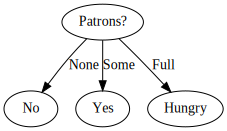

In [48]:
dot = graphviz.Digraph(comment='The Round Table')

dot.node('A', 'Patrons?')
dot.node('B', 'No')
dot.node('L', 'Yes')
dot.node('C', 'Hungry')

dot.edge('A', 'B', label='None')
dot.edge('A', 'L', label='Some')
dot.edge('A', 'C', label='Full')
#dot.edges(['AB', 'AL'])
#dot.edge('B', 'L', constraint='false')

dot